# Spatial Analysis of racial and income inequality in São Paulo

Notebook for the Capstone Project IBM Data Science course.\
By André Leite Rodrigues

## 1. Introduction

Brazil has the second highest concentration of income in the world, says UN report [1]. In Brazil, the richest 1% concentrates 28.3% of the country's total income. That is, almost a third of the income is in the hands of the wealthiest. The richest 10% in Brazil, on the other hand, account for 41.9% of the total income.\
\
This inequality of income reflects in the occupation of urban spaces. In the city of São Paulo it's possible see big mansions in the best places of the city (in terms of infrastructure) in contrast with big favelas in the poorest places.\
\
But in addition to income inequality, Brazil still faces a problem of structural racism. Dimensions of our history and culture that have allowed privileges associated with “whiteness” and disadvantages associated with “color” to endure and adapt over time.[2] Brazil was the last country in the Americas to abolish slavery. Without compensation or preparation to insert these ex-slaves into society and without treating racism as a problem, more than 130 years after the abolition the Brazilian inequality is colored: the majority of the poor population is black in contrast to the rich population where the majority is white .

### 1.1	 Objective

Use the techniques learned during the 9 modules of the Data Science course offered by IBM on the Coursera platform to analyze the census data from São Paulo in order to understand whether race, income and infrastructure have a correlation and whether it is possible to identify groups of these variables in the map of São Paulo.

## 2.	Data acquisition and source

First, the census data from the Brazilian Institute of Geography and Statistics (IBGE) will be analyzed [3]. The IBGE promotes the national census every 10 years, but due to COVID-19 this year's census is delayed. Therefore, in this study I will use the data from the 2010 census. The census data are available for everyone to access on the Internet at www.ibge.gov.br in the downloads section> Census> 2010 population census> Universe results> Aggregated by census sectors . You can download all research documentation as well.\

The files used for this analysis will be:

•	DomicílioRenda_SP1.csv: file containing the average nominal income of the census sector. From this table, the following variables will be used:\
o	Cod_setor:  census sector id;\
o	V002: Total nominal monthly income of private households.

•	Pessoa03_UF.csv: file containing the number of resident people and the declared race. From this table the following variables will be used:\
o	Cod_setor: census sector id;\
o	V001: Total resident people;\
o	V003: Resident people and color or race - black;\
o	V005: Resident people and color or race - brown;

The geographical unit worked on in this study is the census sector. The census sector is the territorial unit established for the purpose of cadastral control, formed by a continuous area, located in a single urban or rural framework, with the size and number of households that allow for the survey by a census taker. IBGE provides the geographical limits of the census sector in .kmz and .shp formats. They are spatial vector formats in the shape of polygons. For this study I will use only the centroid of these areas as a geographical reference, transforming the polygons into points and converting them to the.json format. The figure below illustrates the division of São Paulo into census sectors.

![SETOR](https://static.wixstatic.com/media/8ff60f_3d95f176c01b42cc91ca334d34a4239b~mv2.jpg)

The city of São Paulo has 18363 census tracts, each sector has an average of 300 households.

To understand the distribution of Health, Education and Culture equipment, forecast data from São Paulo will be used, available at http://geosampa.prefeitura.sp.gov.br/.

To access the data just enter the website and go to "downloads"> "equipment" and choose as bases. All variables already have a mark to which census sector they belong to.Finally, the last database will be built by Foursquare's API venues. It is mandatory and I will extract information from two diferente districts for compare.


## 3. Methodology

Fist, install and import librarys

In [18]:
!pip -q install folium
!pip -q install geopy

In [19]:
import numpy as np
import pandas as pd
import json
import geopy
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

### 3.1 Space census sector data cleaning and structuring

The first data treated is the census sectors. Firstly, this data is made available in the shapefile (.shp) format, so I started its treatment in a specific tool for spatial data, ArcGIS. There are other tools available for download that can provide the treatment of this data, but as I have the ArcGIS license I preferred to work with this tool using the python language and its arcpy library.

After downloading from the IBGE website, some treatments are required to use the data. IBGE uses the SIRGAS 2000 cartographic reference system, but most open maps work with WGS84. Cartographic projections are systems of geographic coordinates, consisting of parallel meridians (imaginary semicircle drawn from one pole of the Earth to another) (imaginary lines parallel to the Equator), on which the spherical surface of the Earth can be represented.
The first step is to project SIRGAS to WGS84. This conversion is necessary so that the sector data are in the same coordinate system as the maps.

In [ ]:
# Import arcpy module
import arcpy

# Local variables:
v33SEE250GC_SIR = "33SEE250GC_SIR"
c33SEE250GC_SIR_Select1 = "C:\\Users\\N5755650\\Documents\\ArcGIS\\Default.gdb\\c33SEE250GC_SIR_Select1"
c33SEE250GC_SIR_Select1_Proj = "C:\\Users\\N5755650\\Documents\\ArcGIS\\Default.gdb\\c33SEE250GC_SIR_Select1_Proj"

# Process: Select
arcpy.Select_analysis(v33SEE250GC_SIR, c33SEE250GC_SIR_Select1, "\"CD_GEOCODM\" = '3550308'")

# Process: Project
arcpy.Project_management(c33SEE250GC_SIR_Select1, c33SEE250GC_SIR_Select1_Proj, "GEOGCS['GCS_WGS_1984',DATUM['D_WGS_1984',SPHEROID['WGS_1984',6378137.0,298.257223563]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]]", "SIRGAS_2000_To_WGS_1984_1", "GEOGCS['GCS_SIRGAS_2000',DATUM['D_SIRGAS_2000',SPHEROID['GRS_1980',6378137.0,298.257222101]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]]", "NO_PRESERVE_SHAPE", "", "NO_VERTICAL")

In this script I selected only the city of São Paulo (3550308), area of ​​interest for the study. Then I transformed the shape from polygons to points and exported it to the json format.

In [ ]:
# Local variables:
c33SEE250GC_SIR_Select1_Proj = "c33SEE250GC_SIR_Select1_Proj"
setor_point = "C:\\Users\\N5755650\\Documents\\ArcGIS\\Default.gdb\\setor_point"
setor_json_json = "C:\\Users\\N5755650\\Desktop\\IBM\\Capstone\\Setor_censitario\\setor_json.json"

# Process: Feature To Point
arcpy.FeatureToPoint_management(c33SEE250GC_SIR_Select1_Proj, setor_point, "CENTROID")

# Process: Features To JSON
arcpy.FeaturesToJSON_conversion(setor_point, setor_json_json, "NOT_FORMATTED", "NO_Z_VALUES", "NO_M_VALUES", "GEOJSON")

Next step is upload json file para o notebook

In [4]:
with open('setor_json.json') as json_data:
    setor_point = json.load(json_data)

The next task is transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe. Then loop through the data and fill the dataframe one row at a time.

In [5]:
setor_data = setor_point['features']

# define the dataframe columns
column_names = ['CD_SETOR', 'CD_DIST', 'NM_DIST', 'LAT', 'LONG'] 

# instantiate the dataframe
setores = pd.DataFrame(columns=column_names)

In [6]:
setor_data[0]

{'type': 'Feature',
 'id': 1,
 'geometry': {'type': 'Point',
  'coordinates': [-46.518793322999954, -23.580867744999978]},
 'properties': {'OBJECTID': 1,
  'CD_GEOCODI': '355030804000079',
  'CD_GEOCODD': '355030804',
  'NM_DISTRIT': 'ARICANDUVA',
  'LAT': -23.580867744892075,
  'LONG': -46.51879332282634,
  'ORIG_FID': 1}}

In [7]:
for data in setor_data:
    cod_setor = data['properties']['CD_GEOCODI']
    cod_dist = data['properties']['CD_GEOCODD']
    NM_DIST = data['properties']['NM_DISTRIT']
    
    latlon = data['geometry']['coordinates']
    lat = latlon[1]
    long = latlon[0]
    
    setores = setores.append({'CD_SETOR': cod_setor,
                                          'CD_DIST': cod_dist,
                                          'NM_DIST': NM_DIST,
                                          'LAT': lat,
                                          'LONG': long}, ignore_index=True)

In [78]:
setores.head(5)

,CD_SETOR,CD_DIST,NM_DIST,LAT,LONG
0,355030804000079,355030804,ARICANDUVA,-23.580868,-46.518793
1,355030804000080,355030804,ARICANDUVA,-23.580699,-46.520071
2,355030804000081,355030804,ARICANDUVA,-23.581415,-46.521093
3,355030804000082,355030804,ARICANDUVA,-23.580942,-46.522501
4,355030804000083,355030804,ARICANDUVA,-23.582057,-46.525141


And to finish this step, a map was created to see if the data are consistent.

In [ ]:
# create map of São Paulo using latitude and longitude values
map_sp = folium.Map(location=[-23.547152, -46.634934], zoom_start=11)

# add markers to map
for lat, long, NM_DIST, CD_SETOR in zip(setores['LAT'], setores['LONG'], setores['NM_DIST'], setores['CD_SETOR']):
    label = '{}, {}'.format(CD_SETOR, NM_DIST)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    

### 3.2 Extracting and preparing FourSquare data – Points of Interest (POI).

As previously described, São Paulo has more than 18,000 census sectors, which would be too much to get all information via the FourSquare API. For specific analysis of points of interest using this API, only 2 districts of the city will be analyzed: Moema and Vila Andrade.

The first step is to register on the FourSquare developer portal, and create a CLIENT ID and CLIENT SECRET for our application. With that we can start the data extraction process.

In [84]:
CLIENT_ID = '2XD1F5NZ5MNIPPVM5FD4CZVRXLBMHIZ524T5PKE4DMXJD5WX' # your Foursquare ID
CLIENT_SECRET = 'LR45O2LHZDOZMJIKBT0VMBND1JN5CVETUII2WK0OWLWN0APN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [290]:
moema = setores[setores['CD_DIST'] == '355030832'].reset_index(drop=True)
moema.head()

,CD_SETOR,CD_DIST,NM_DIST,LAT,LONG
0,355030832000144,355030832,MOEMA,-23.605718,-46.663424
1,355030832000145,355030832,MOEMA,-23.605008,-46.661929
2,355030832000146,355030832,MOEMA,-23.613246,-46.662828
3,355030832000147,355030832,MOEMA,-23.573885,-46.655216
4,355030832000148,355030832,MOEMA,-23.606396,-46.664017


In [307]:
vila_andrade = setores[setores['CD_DIST'] == '355030883'].reset_index(drop=True)
vila_andrade.head()

,CD_SETOR,CD_DIST,NM_DIST,LAT,LONG
0,355030883000073,355030883,VILA ANDRADE,-23.619246,-46.723707
1,355030883000074,355030883,VILA ANDRADE,-23.620158,-46.724846
2,355030883000075,355030883,VILA ANDRADE,-23.618117,-46.707971
3,355030883000076,355030883,VILA ANDRADE,-23.618224,-46.725569
4,355030883000077,355030883,VILA ANDRADE,-23.616790,-46.743777


After that, a process was made to consult each of the id codes of the census sectors and search for the first 10 venues within a radius of 500 meters, creating a table containing with the CD_SETOR, the Venue and its category (in addition to the respective latitudes and longitudes).

In [164]:
LIMIT=10
radius=500

In [300]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)       
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
                             
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['CD_SETOR', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [301]:
moema_venues = getNearbyVenues(names=moema['CD_SETOR'], latitudes=setores['LAT'], longitudes=setores['LONG'])

355030832000144
355030832000145
355030832000146
355030832000147
355030832000148
355030832000149
355030832000150
355030832000151
355030832000152
355030832000153
355030832000154
355030832000155
355030832000156
355030832000157
355030832000158
355030832000001
355030832000002
355030832000003
355030832000004
355030832000005
355030832000006
355030832000007
355030832000008
355030832000009
355030832000010
355030832000011
355030832000012
355030832000013
355030832000014
355030832000015
355030832000016
355030832000017
355030832000018
355030832000019
355030832000020
355030832000021
355030832000022
355030832000023
355030832000024
355030832000025
355030832000026
355030832000027
355030832000028
355030832000029
355030832000030
355030832000031
355030832000032
355030832000033
355030832000034
355030832000035
355030832000036
355030832000037
355030832000038
355030832000039
355030832000040
355030832000041
355030832000042
355030832000043
355030832000044
355030832000045
355030832000046
355030832000047
35503083

In [304]:
moema_venues.head()

,CD_SETOR,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,355030832000144,-23.580868,-46.518793,Pastelaria Ki Delícia,-23.578314,-46.517249,Pastelaria
1,355030832000144,-23.580868,-46.518793,Robruel Fitness,-23.582432,-46.518864,Gym
2,355030832000144,-23.580868,-46.518793,Boutique do Pão,-23.582946,-46.517506,Bakery
3,355030832000144,-23.580868,-46.518793,Drogaria São Paulo,-23.577447,-46.516724,Pharmacy
4,355030832000144,-23.580868,-46.518793,Cia Mega Fitness,-23.576740,-46.517256,Gymnastics Gym


The same procedure was carried out for the Vila Andrade district.

In [308]:
vila_andrade = getNearbyVenues(names=vila_andrade['CD_SETOR'], latitudes=setores['LAT'], longitudes=setores['LONG'])

355030883000073
355030883000074
355030883000075
355030883000076
355030883000077
355030883000078
355030883000079
355030883000080
355030883000081
355030883000082
355030883000083
355030883000084
355030883000085
355030883000086
355030883000185
355030883000186
355030883000187
355030883000188
355030883000189
355030883000190
355030883000191
355030883000192
355030883000193
355030883000194
355030883000195
355030883000196
355030883000197
355030883000198
355030883000001
355030883000002
355030883000003
355030883000004
355030883000005
355030883000006
355030883000007
355030883000008
355030883000009
355030883000010
355030883000011
355030883000012
355030883000013
355030883000014
355030883000015
355030883000016
355030883000017
355030883000018
355030883000019
355030883000020
355030883000021
355030883000022
355030883000023
355030883000024
355030883000025
355030883000026
355030883000027
355030883000028
355030883000029
355030883000030
355030883000031
355030883000032
355030883000033
355030883000034
35503088

In [309]:
vila_andrade.head()

,CD_SETOR,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,355030883000073,-23.580868,-46.518793,Pastelaria Ki Delícia,-23.578314,-46.517249,Pastelaria
1,355030883000073,-23.580868,-46.518793,Robruel Fitness,-23.582432,-46.518864,Gym
2,355030883000073,-23.580868,-46.518793,Boutique do Pão,-23.582946,-46.517506,Bakery
3,355030883000073,-23.580868,-46.518793,Drogaria São Paulo,-23.577447,-46.516724,Pharmacy
4,355030883000073,-23.580868,-46.518793,Cia Mega Fitness,-23.576740,-46.517256,Gymnastics Gym


In [310]:
vila_andrade.shape

(2122, 7)

Finally, the data was exported to csv files.

In [312]:
moema_venue.to_csv(r'C:\Users\N5755650\Desktop\IBM\Capstone\moema.csv')

In [313]:
vila_andrade.to_csv(r'C:\Users\N5755650\Desktop\IBM\Capstone\vl_andrade.csv')

### 3.3. Creating SQL DataBase in IBM Db2 on Cloud

A cloud database is a database service built and accessed through a cloud platform. It serves many of the same functions as traditional databases with the added flexibility of cloud computing.

To create this database I navigate to IBM Cloud and select the Db2 on Cloud service. Type a service instance name, choose the region to deploy to, as well as an org and space for the service, then click create. You should be able to see details related to connection configuration when you open the web console for the Db2 on Cloud service. The connection details include the following: a host name, which is a unique name or label assigned to any device that is connected to a specific computer network. A port number, which is the database port. The database name, which is the database name. A user ID, which is the username you'll use to connect. Password, is the password you'll use to connect.

#### 3.3.1. Loading Tables 

The follow tables was load in Db2:
•	Pessoa03_SP1.csv as POPULATION: this table contain the data about color, race and gender from IBGE CENSUS;
•	DomicílioRenda_SP1.csv as INCOME: this table contain the data about income from IBGE CENSUS;
•	GEOINFO_CT_CULTURA_2018_Variáveis.csv as CULTURA: Information from São Paulo city about culture equipaments like librarys, theaters;
•	GEOINFO_CT_EDUCACAO_2018_Variáveis.csv as EDUCATION: Information from São Paulo city about schools and students;
•	GEOINFO_CT_SAUDE_2018_Variáveis.csv as HEALTH: Information from São Paulo city about clinics, First Aid centers, Hospitals and beds;
•	Setores_censo_2010 as SETORES: Information about sector ID and district id.

To upload tables, it’s just open IBM Db2 console and click in Load Data, choose the file, elect a load target, create new table, verify the fields and upload


#### 3.3.2. Prepare table Summary sector 

Import and load the SQL extension. 

In [1]:
%load_ext sql
import ibm_db
import pandas
import ibm_db_dbi

Create a database connection with my credentials and conect with my database.

In [2]:
#Replace the placeholder values with the actuals for your Db2 Service Credentials
dsn_driver = "{BLUDB}"
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_hostname = "dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net"            # e.g.: "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_port = "50000"                    # e.g. "50000" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_uid = "lqx82186"                 # e.g. "abc12345"
dsn_pwd = "q23px8b3cn8n-lfk"                 # e.g. "7dBZ3wWt9XN6$o0J"

In [3]:
#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  lqx82186 on host:  dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net


In [4]:
%sql ibm_db_sa://lqx82186:q23px8b3cn8n-lfk@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB

'Connected: lqx82186@BLUDB'

Using SQL query, I group by sector ID, count the number of equipaments per sector and sum the number of students in EDUCATION table. I Do the same metodology for HEALTH but sum the number of hospital beds e for CULTURE I just count the number of equipaments.

In [5]:
%sql select * from EDUCATION limit 5

 * ibm_db_sa://lqx82186:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


id,coord_e,coord_n,setcens,areap,coddist,distrito,codsubpref,subpref,regiao5,regiao8,nomesc,endesc,numesc,complend,endereco_a,baiesc,cep,fone1,fone2,email,ed_diretor,diretoria,dre,ed_zona,zona,codesc,codescmec,ed_depadm,depadm,ed_tipo,tipo,ed_categ,categ,alcreche,alpre,alee,al9ini,al9fin,alem,alprof,aleja1a4,aleja5a8,alejaem,al_total,clcreche,clpre,cl9ini,cl9fin,clem
1,315396.89,7406487.32,355030803000111,3550308005307,3,ANHANGUERA,1,PERUS,Norte,Norte 2,EMEF MARILI DIAS PROFA,RUA ANTONIO CONSELHEIRO,1,RUA,RUA ANTONIO CONSELHEIRO 1,VILA DOS PALMARES,5273140,39163375,39163376,EMEFMARILIDIAS@PREFEITURA.SP.GOV.BR,10101,NORTE 1,PIRITUBA,1,URBANA,355185,35355185,2,MUNICIPAL,310,EMEF,1,ESCOLAS AUTONOMAS,0,0,0,496,449,0,0,0,0,0,945,0,0,17,15,0
2,315463.46,7406948.59,355030803000121,3550308005307,3,ANHANGUERA,1,PERUS,Norte,Norte 2,CR P CONV FAMILIA JUDA,PIRAPORA,101,ESTRADA,ESTRADA PIRAPORA 101,JARDIM JARAGUA,5275010,39112876,965342165,CEIFAMJUDA@GMAIL.COM,10101,NORTE 1,PIRITUBA,1,URBANA,579324,35579324,3,PRIVADA,308,CR.P.CONV,1,ESCOLAS AUTONOMAS,165,0,0,0,0,0,0,0,0,0,165,12,0,0,0,0
3,315875.17,7390513.93,355030865000080,3550308005240,65,RAPOSO TAVARES,10,BUTANTA,Oeste,Oeste,CEI DIRET CIDADE DE GENEBRA,CACHOEIRA PORAQUE,100,RUA,RUA CACHOEIRA PORAQUE 100,CONJUNTO PROMORAR RAPOSO TAVARES,5574450,37811290,None,None,10312,CENTRO OESTE,BUTANTA,1,URBANA,279262,35279262,2,MUNICIPAL,303,CEI DIRET,1,ESCOLAS AUTONOMAS,153,0,0,0,0,0,0,0,0,0,153,15,0,0,0,0
4,315920.08,7406712.74,355030803000055,3550308005307,3,ANHANGUERA,1,PERUS,Norte,Norte 2,CR P CONV REGINA SIMOES,DALVA DE OLIVEIRA,84,RUA,RUA DALVA DE OLIVEIRA 84,RESIDENCIAL SOL NASCENTE,5282010,None,None,None,10101,NORTE 1,PIRITUBA,1,URBANA,198171,35198171,3,PRIVADA,308,CR.P.CONV,1,ESCOLAS AUTONOMAS,100,0,0,0,0,0,0,0,0,0,100,8,0,0,0,0
5,315948.31,7389966.69,355030865000213,3550308005240,65,RAPOSO TAVARES,10,BUTANTA,Oeste,Oeste,EMEF VILA MUNCK,JOAQUIM GUIMARAES,None,RUA,RUA JOAQUIM GUIMARAES,BUTANTA,5574010,37823682,None,EMEFVMUNCK@PREFEITURA.SP.GOV.BR,10312,CENTRO OESTE,BUTANTA,1,URBANA,428851,35428851,2,MUNICIPAL,310,EMEF,1,ESCOLAS AUTONOMAS,0,0,0,334,200,0,0,0,0,0,534,0,0,14,8,0


In [5]:
%sql select setcens, al_total  from EDUCATION limit 5

 * ibm_db_sa://lqx82186:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


setcens,al_total
355030803000111,945
355030803000121,165
355030865000080,153
355030803000055,100
355030865000213,534


In [6]:
%sql select setcens, count(id) as tt_schools, sum(al_total) as tt_students from EDUCATION group by setcens limit 5

 * ibm_db_sa://lqx82186:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


setcens,tt_schools,tt_students
355030801000000,2,354
355030801000003,2,536
355030801000005,1,6
355030801000012,1,273
355030801000014,1,228


In [5]:
pconn = ibm_db_dbi.Connection(conn)

In [15]:
#query statement to retrieve all rows in INSTRUCTOR table
selectQuery = "select setcens, count(id) as tt_schools, sum(al_total) as tt_students from EDUCATION group by setcens"

#retrieve the query results into a pandas dataframe
SETORES_EDUC = pandas.read_sql(selectQuery, pconn)

SETORES_EDUC.head(10)

,SETCENS,TT_SCHOOLS,TT_STUDENTS
0,355030801000000,2.0,354
1,355030801000003,2.0,536
2,355030801000005,1.0,6
3,355030801000012,1.0,273
4,355030801000014,1.0,228
5,355030801000015,1.0,252
6,355030801000018,1.0,58
7,355030801000019,1.0,143
8,355030801000021,1.0,54
9,355030801000023,1.0,253


In [39]:
SETORES_EDUC.to_csv(r'setores_educ.csv')

In [40]:
%sql select * from CULTURE limit 5

 * ibm_db_sa://lqx82186:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


id,coord_e,coord_n,setcens,areap,coddist,distrito,codsubpref,subpref,regiao5,regiao8,nome,espaco,endereco,telefone,bairro,cep,ct_tipo,ct_depadm,inauguracao,assentos,acessibilidade,estacionamento
1,331655.08,7395177.62,355030826000098,3550308005012,26,CONSOLACAO,9,SE,Centro,Centro,Monteiro Lobato (Inclui �nibus Biblioteca),Biblioteca,"R Gal Jardim, 485",3256-4122,V. Buarque,01223-01,1,1,4/14/1936,None,Atende �s normas,Sim
2,358921.74,7402841.68,355030844000190,3550308005247,44,JARDIM HELENA,23,SAO MIGUEL,Leste,Leste 2,CEU Tr�s Pontes,CEU,"R Capach�s, s/n",3397-6410,Jardim C�lia,08191-330,2,1,None,None,Sem informa�,Sem informa�
3,358093.23,7398974.85,355030836000285,3550308005254,36,ITAIM PAULISTA,24,ITAIM PAULISTA,Leste,Leste 2,Paulo Leminski - CEU Parque Veredas,CEU,"R Daniel Pedro Muller, s/n- Camargo Velho",65636249,Camargo Velho,None,2,1,9/15/2003,None,Sem informa�,Sem informa�
4,357327.02,7400633.28,355030836000105,3550308005249,36,ITAIM PAULISTA,24,ITAIM PAULISTA,Leste,Leste 2,Ponto de Leitura Severino do Ramo,Biblioteca - Extens,"R Bar�o de Alagoas, 340",2936-2742,Itaim Paulista,None,2,1,7/1/2011,80,N�o atende �s normas,Sem informa�
5,357248.70,7389261.40,355030825000286,3550308005272,25,CIDADE TIRADENTES,31,CIDADE TIRADENTES,Leste,Leste 2,Ponto de Leitura Andr� Vital,Biblioteca- Extens,"Av dos Metal�rgicos, 2255",2282-2562,Cidade Tiradentes,08470-000,2,1,7/17/2006,None,Sem informa�,Sem informa�


In [41]:
%sql select setcens, count(id) as tt_culture_equp from CULTURE group by setcens limit 5

 * ibm_db_sa://lqx82186:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


setcens,tt_culture_equp
355030801000118,2
355030802000010,1
355030802000029,1
355030802000037,1
355030802000039,1


In [45]:
#query statement to retrieve all rows in INSTRUCTOR table
selectQuery2 = "select setcens, count(id) as tt_culture_equp from CULTURE group by setcens"

#retrieve the query results into a pandas dataframe
SETORES_CULT = pandas.read_sql(selectQuery2, pconn)

SETORES_CULT.head(10)

,SETCENS,TT_CULTURE_EQUP
0,3.550308e+14,2.0
1,3.550308e+14,1.0
2,3.550308e+14,1.0
3,3.550308e+14,1.0
4,3.550308e+14,1.0
5,3.550308e+14,1.0
6,3.550308e+14,9.0
7,3.550308e+14,1.0
8,3.550308e+14,1.0
9,3.550308e+14,2.0


In [46]:
SETORES_CULT.to_csv(r'setores_cult.csv')

In [47]:
%sql select * from HEALTH limit 5

 * ibm_db_sa://lqx82186:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


id,coord_e,coord_n,setcens,areap,coddist,distrito,codsubpref,subpref,regiao5,regiao8,estabelecimento,endereco,bairro,telefone,cep,cnes,sa_depadm,depadm,sa_tipo,tipo,sa_classe,classe,leitos
1,319108.42,7380764.47,355030819000016,3550308005232,19,CAPAO REDONDO,17,CAMPO LIMPO,Sul,Sul 2,CAPAO REDONDO - AMA ESPECIALIDADES,"AV COMEN SANT'ANNA, 774",JD. BOA ESPERANCA,58729902,5866000,6194974,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,None
2,331055.43,7400384.23,355030821000001,3550308005062,21,CASA VERDE,4,CASA VERDE-CACHOEIRINHA,Norte,Norte 2,PQ PERUCHE-AMA ESPECIALIDADES,"R JOSE RANGEL DE CAMARGO, 500",PQ PERUCHE,38589865,2538010,6148336,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,None
3,330196.17,7380955.02,355030822000066,3550308005164,22,CIDADE ADEMAR,16,CIDADE ADEMAR,Sul,Sul 2,V CONSTANCIA -AMA ESPECIALIDADES,"R HERMENEGILDO MARTINI, SN",V CONSTANCIA,55626944,4438280,6415415,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,None
4,326183.88,7373067.87,355030823000196,3550308005287,23,CIDADE DUTRA,19,CAPELA DO SOCORRO,Sul,Sul 2,JD ICARAI I (QUINTANA) -AMA ESPECIALIDADES,"R S ROQUE DO PARAGUACU, 190",V QUINTANA,59280272,4837150,6360890,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,None
5,351434.05,7396009.19,355030837000019,3550308005202,37,ITAQUERA,27,ITAQUERA,Leste,Leste 2,ITAQUERA-AMA ESPECIALIDADES,"R AMERICO SALVADOR NOVELLI, 265",ITAQUERA,20712422,8210090,6394558,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,None


In [48]:
%sql select setcens, count(id), sum(leitos) as tt_health_equp from HEALTH group by setcens limit 5

 * ibm_db_sa://lqx82186:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


setcens,2,tt_health_equp
3550308005006,1,348.000
355030801000007,3,6.000
355030801000090,1,None
355030801000122,1,None
355030802000002,1,None


In [80]:
#query statement to retrieve all rows in INSTRUCTOR table
selectQuery3 = "select setcens, count(id) tt_health_equip, sum(leitos) as tt_leitos from HEALTH group by setcens"

#retrieve the query results into a pandas dataframe
SETORES_SAUDE = pandas.read_sql(selectQuery3, pconn)

SETORES_SAUDE.head(10)

,SETCENS,TT_HEALTH_EQUIP,TT_LEITOS
0,3550308005006,1.0,348.0
1,355030801000007,3.0,6.0
2,355030801000090,1.0,NaN
3,355030801000122,1.0,NaN
4,355030802000002,1.0,NaN
5,355030802000062,4.0,6.0
6,355030803000007,1.0,NaN
7,355030803000014,1.0,NaN
8,355030803000094,1.0,NaN
9,355030803000105,1.0,NaN


This results in 3 new tables, who I export to csv and upload in Db2 as SETOR_CULT, SETOR_EDUC and SETOR_HEALTH.

In [81]:
SETORES_SAUDE.to_csv(r'setores_saude.csv')

The sector id is may key between this tables. Using the follow script I created the summary_sector table and use pandas.read_sql to create a pandas table

In [6]:
#query statement to retrieve all rows in INSTRUCTOR table
selectSummary_sector = "SELECT Setores.CD_SETOR, Setores.CD_DIST, Setores.NM_DIST, POPULATION.V001 AS Pop_TT, POPULATION.V002 AS Pop_white, DOUBLE(POPULATION.V002)/DOUBLE(POPULATION.V001) AS PERC_WHITE, POPULATION.V003+POPULATION.V005 AS Pop_black, DOUBLE(POPULATION.V003+POPULATION.V005)/DOUBLE(POPULATION.V001) AS PERC_BLACK, POPULATION.V004+POPULATION.V006 AS POP_other, DOUBLE(POPULATION.V004+POPULATION.V006)/DOUBLE(POPULATION.V001) AS PERC_OTHER, INCOME.V002 AS TT_INCOME, DOUBLE(INCOME.V002)/DOUBLE(POPULATION.V001) AS INCOME_PER_CAPTA, POPULATION.VMAN AS MAN, DOUBLE(POPULATION.VMAN)/DOUBLE(POPULATION.V001) AS PERC_MAN, POPULATION.VWOMAN AS WOMAN, DOUBLE(POPULATION.VWOMAN)/DOUBLE(POPULATION.V001) AS PERC_WOMAN, SETOR_EDUC.TT_SCHOOLS, SETOR_EDUC.TT_STUDENTS, SETOR_CULT.TT_CULTURE_EQUP, SETOR_HEALTH.TT_HEALTH_EQUIP, SETOR_HEALTH.TT_LEITOS, Setores.LAT, Setores.LONG FROM ((((Setores LEFT JOIN POPULATION ON Setores.CD_SETOR = POPULATION.Cod_setor) LEFT JOIN INCOME ON Setores.CD_SETOR = INCOME.Cod_setor) LEFT JOIN SETOR_EDUC ON Setores.CD_SETOR = SETOR_EDUC.SETCENS) LEFT JOIN SETOR_CULT ON Setores.CD_SETOR = SETOR_CULT.SETCENS) LEFT JOIN SETOR_HEALTH ON Setores.CD_SETOR = SETOR_HEALTH.SETCENS WHERE (((POPULATION.V001) Is Not Null));"

Summary_sector = pandas.read_sql(selectSummary_sector, pconn)

Summary_sector.head(5)

,CD_SETOR,CD_DIST,NM_DIST,POP_TT,POP_WHITE,PERC_WHITE,POP_BLACK,PERC_BLACK,POP_OTHER,PERC_OTHER,...,PERC_MAN,WOMAN,PERC_WOMAN,TT_SCHOOLS,TT_STUDENTS,TT_CULTURE_EQUP,TT_HEALTH_EQUIP,TT_LEITOS,LAT,LONG
0,355030802000076,355030802,ALTO DE PINHEIROS,548,497,0.906934,27,0.049270,24,0.043796,...,0.481752,284,0.518248,1.0,64.0,NaN,NaN,NaN,-23.53822883899994,-46.71332882699994
1,355030801000001,355030801,3GUA RASA,806,661,0.820099,142,0.176179,3,0.003722,...,0.465261,431,0.534739,NaN,NaN,NaN,NaN,NaN,-23.567837779999934,-46.570826168999986
2,355030801000002,355030801,3GUA RASA,913,730,0.799562,179,0.196057,4,0.004381,...,0.451260,501,0.548740,NaN,NaN,NaN,NaN,NaN,-23.566559651999967,-46.56823083399996
3,355030801000003,355030801,3GUA RASA,625,521,0.833600,96,0.153600,8,0.012800,...,0.476800,327,0.523200,2.0,536.0,NaN,NaN,NaN,-23.56859691899996,-46.56752940999996
4,355030801000004,355030801,3GUA RASA,572,430,0.751748,134,0.234266,8,0.013986,...,0.482517,296,0.517483,NaN,NaN,NaN,NaN,NaN,-23.570316633999937,-46.56888325999995


In [28]:
Summary_sector.shape

(18363, 17)

In [29]:
Summary_sector.to_csv(r'summary_sector.csv')

### 3.4. Exploratory Data Analysis

In [9]:
import pandas as pd
import numpy as np
#! pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
from scipy import stats

For a first view of the Summary_sector table I use the .describe () function so I can evaluate the count, average, standard deviation, minimum, maximum and quartiles for each variable.

In [17]:
Summary_sector.describe()

,POP_TT,POP_WHITE,PERC_WHITE,POP_BLACK,PERC_BLACK,POP_OTHER,PERC_OTHER,TT_INCOME,INCOME_PER_CAPTA,MAN,PERC_MAN,WOMAN,PERC_WOMAN,TT_SCHOOLS,TT_STUDENTS,TT_CULTURE_EQUP,TT_HEALTH_EQUIP,TT_LEITOS
count,18363.000000,18363.000000,18363.000000,18363.000000,18363.000000,18363.000000,18363.000000,1.836300e+04,18363.000000,18363.000000,18363.000000,18363.000000,18363.000000,4727.000000,4727.000000,721.000000,855.000000,235.000000
mean,612.835757,371.526820,0.619319,226.937701,0.346997,14.113108,0.025114,6.878029e+05,1249.694221,289.927735,0.468316,322.672276,0.523177,1.462238,572.380791,2.327323,1.297076,111.744681
std,314.424174,191.798473,0.195682,206.294280,0.203736,24.081993,0.041362,7.187901e+05,1349.390121,153.588338,0.054736,163.043408,0.058847,0.846567,965.872058,2.544807,0.757896,147.784069
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,408.000000,243.000000,0.463293,69.000000,0.160052,2.000000,0.003610,2.789845e+05,460.893023,190.000000,0.454662,217.000000,0.510436,1.000000,119.000000,1.000000,1.000000,15.000000
50%,584.000000,357.000000,0.618557,178.000000,0.353383,7.000000,0.012500,4.699370e+05,712.662434,274.000000,0.472296,310.000000,0.527174,1.000000,301.000000,1.000000,1.000000,73.000000
75%,779.000000,486.000000,0.785928,324.000000,0.522600,17.000000,0.030888,8.130405e+05,1452.268650,370.000000,0.488942,411.000000,0.544608,2.000000,792.000000,2.000000,1.000000,164.000000
max,3252.000000,1834.000000,1.000000,2217.000000,1.000000,599.000000,1.000000,1.348729e+07,26088.791946,1773.000000,1.000000,1678.000000,1.000000,10.000000,47268.000000,17.000000,8.000000,1031.000000


As expected, the variables related to population and income are filled for all 18,363 census sectors.
Only 4,727 sectors have schools, 721 cultural facilities and 855 health facilities. Therefore, I will exclude the use of this information for analysis at the scale of the census sector. This information will be better used when the level of scale is the district.
Given this, I establish the correlation between the proportional variables of the population in each district and the per-capita income.


In [21]:
Summary_sector[['PERC_WHITE','PERC_BLACK','PERC_OTHER','PERC_MAN', 'PERC_WOMAN', 'INCOME_PER_CAPTA']].corr()

,PERC_WHITE,PERC_BLACK,PERC_OTHER,PERC_MAN,PERC_WOMAN,INCOME_PER_CAPTA
PERC_WHITE,1.000000,-0.878427,0.250231,0.047822,0.414930,0.662489
PERC_BLACK,-0.878427,1.000000,-0.417850,0.320795,-0.050454,-0.660883
PERC_OTHER,0.250231,-0.417850,1.000000,-0.038468,0.123963,0.312490
PERC_MAN,0.047822,0.320795,-0.038468,1.000000,0.313626,-0.079512
PERC_WOMAN,0.414930,-0.050454,0.123963,0.313626,1.000000,0.208240
INCOME_PER_CAPTA,0.662489,-0.660883,0.312490,-0.079512,0.208240,1.000000


By the Pearson correlation index, a moderate / strong correlation was identified between income and percentages of white and black people, however the correlation at the level of the census sector was weak in relation to gender. There is also a strong correlation between the percentages of whites and blacks, which may indicate that there may be spatial segregation.

In [ ]:
Summary_sector[['POP_TT','POP_WHITE','POP_BLACK','POP_OTHER','MAN', 'WOMAN', 'INCOME_PER_CAPTA','TT_SCHOOLS', 'TT_STUDENTS', 'TT_CULTURE_EQUP', 'TT_HEALTH_EQUIP', 'TT_LEITOS']].corr()

WHITE PEOPLE

The white population of the city represents 60.6% of the total declared to the IBGE. When constructing the dispersion graph of the census areas, we can observe that there is a growth correlation between the percentage of white people in the sector and the income per capita.

In [28]:
Summary_sector[['POP_TT', 'POP_WHITE']].sum()

POP_TT       11253503
POP_WHITE     6822347
dtype: int64

In [29]:
6822347/11253503

0.6062420741346051

(0, 27488.921936962033)

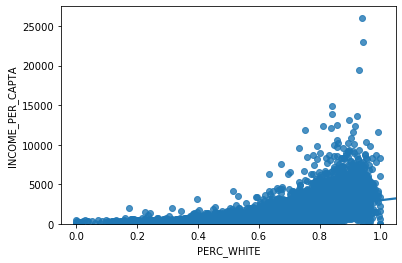

In [24]:
sns.regplot(x='PERC_WHITE', y='INCOME_PER_CAPTA', data=Summary_sector)
plt.ylim(0,)

In [25]:
Summary_sector[["PERC_WHITE", "INCOME_PER_CAPTA"]].corr()

,PERC_WHITE,INCOME_PER_CAPTA
PERC_WHITE,1.000000,0.662489
INCOME_PER_CAPTA,0.662489,1.000000


In [45]:
pearson_coef, p_value = stats.pearsonr(Summary_sector['PERC_WHITE'], Summary_sector['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.6624886961070122  with a P-value of P = 0.0


BLACK PEOPLE

The city's black population represents 37% of the total declared to the IBGE. When constructing the dispersion graph of the census areas, we can observe that there is a decreasing correlation between the percentage of black people in the sector and the income per capita.

In [30]:
Summary_sector[['POP_TT', 'POP_BLACK']].sum()

POP_TT       11253503
POP_BLACK     4167257
dtype: int64

In [31]:
4167257/11253503

0.3703075389058856

(0, 27489.645882087167)

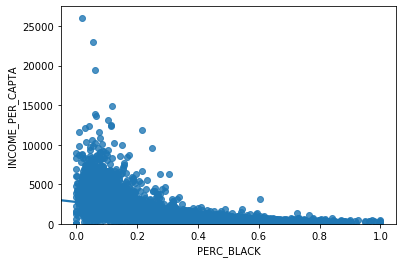

In [26]:
sns.regplot(x='PERC_BLACK', y='INCOME_PER_CAPTA', data=Summary_sector)
plt.ylim(0,)

In [27]:
Summary_sector[["PERC_BLACK", "INCOME_PER_CAPTA"]].corr()

,PERC_BLACK,INCOME_PER_CAPTA
PERC_BLACK,1.000000,-0.660883
INCOME_PER_CAPTA,-0.660883,1.000000


In [46]:
pearson_coef, p_value = stats.pearsonr(Summary_sector['PERC_BLACK'], Summary_sector['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.6608830124388987  with a P-value of P = 0.0


MEN

In [32]:
Summary_sector[['POP_TT', 'MAN']].sum()

POP_TT    11253503
MAN        5323943
dtype: int64

In [33]:
5323943/11253503

0.4730920674211399

(0, 27404.01179022513)

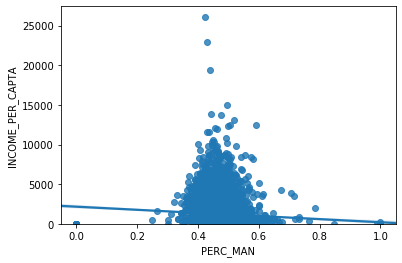

In [36]:
sns.regplot(x='PERC_MAN', y='INCOME_PER_CAPTA', data=Summary_sector)
plt.ylim(0,)

In [37]:
Summary_sector[["PERC_MAN", "INCOME_PER_CAPTA"]].corr()

,PERC_MAN,INCOME_PER_CAPTA
PERC_MAN,1.000000,-0.079512
INCOME_PER_CAPTA,-0.079512,1.000000


In [47]:
pearson_coef, p_value = stats.pearsonr(Summary_sector['PERC_MAN'], Summary_sector['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.07951240563479849  with a P-value of P = 3.7925656303285465e-27


WOMEN

In [38]:
Summary_sector[['POP_TT', 'WOMAN']].sum()

POP_TT    11253503
WOMAN      5925231
dtype: int64

In [39]:
5925231/11253503

0.5265232523597319

(0, 27479.81085337852)

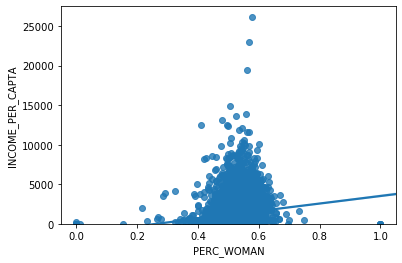

In [41]:
sns.regplot(x='PERC_WOMAN', y='INCOME_PER_CAPTA', data=Summary_sector)
plt.ylim(0,)

In [42]:
Summary_sector[["PERC_WOMAN", "INCOME_PER_CAPTA"]].corr()

,PERC_WOMAN,INCOME_PER_CAPTA
PERC_WOMAN,1.00000,0.20824
INCOME_PER_CAPTA,0.20824,1.00000


In [48]:
pearson_coef, p_value = stats.pearsonr(Summary_sector['PERC_WOMAN'], Summary_sector['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.20824026521970707  with a P-value of P = 4.967431589549382e-179


### By Districts

Districts are territories in which municipalities are subdivided into which administrative, judicial, fiscal, police or health authority is exercised. Each census sector is spatially contained in a district of the city. All 18,363 census sector areas can be grouped into 96 city districts.
The first 9 digits of the sector ID form the district ID.
The first step was to group the CD_DIST column using the groupby function and sum the variables with absolute values. Then, all variables were proportional to the total number of the population for us to compare, including information on health equipment, culture and schools.


In [22]:
District = Summary_sector.groupby(['CD_DIST'],as_index=False).sum()
District.head()

,CD_DIST,POP_TT,POP_WHITE,PERC_WHITE,POP_BLACK,PERC_BLACK,POP_OTHER,PERC_OTHER,TT_INCOME,INCOME_PER_CAPTA,MAN,PERC_MAN,WOMAN,PERC_WOMAN,TT_SCHOOLS,TT_STUDENTS,TT_CULTURE_EQUP,TT_HEALTH_EQUIP,TT_LEITOS
0,355030801,84963,71095,108.540400,11719,18.083233,2149,3.376367,114911602,169282.585750,39100,59.810002,45863,70.189998,53.0,14417.0,2.0,5.0,6.0
1,355030802,43117,38262,69.130447,3475,6.275676,1380,2.593877,170039733,305055.767286,19420,35.132418,23697,42.867582,26.0,10563.0,16.0,5.0,6.0
2,355030803,65859,32321,50.148544,33065,48.169491,403,0.681965,34768395,51512.735382,32389,48.852230,33403,50.197727,41.0,16865.0,4.0,4.0,0.0
3,355030804,89622,62365,86.430951,24676,34.034914,2581,3.534135,71198307,96937.964210,42481,58.723329,47141,65.276671,54.0,19778.0,2.0,3.0,0.0
4,355030805,105269,64722,92.374812,39028,54.280654,1519,2.344534,77883540,112511.750498,49139,69.442076,56130,79.557924,66.0,24360.0,2.0,8.0,0.0


In [23]:
District['PERC_WHITE']=District['POP_WHITE']/District['POP_TT']

In [24]:
District['PERC_BLACK']=District['POP_BLACK']/District['POP_TT']

In [25]:
District['PERC_OTHER']=District['POP_OTHER']/District['POP_TT']

In [26]:
District['INCOME_PER_CAPTA']=District['TT_INCOME']/District['POP_TT']

In [27]:
District['PERC_MAN']=District['MAN']/District['POP_TT']

In [28]:
District['PERC_WOMAN']=District['WOMAN']/District['POP_TT']

In [29]:
District['PERC_SCHOOLS']=District['TT_SCHOOLS']/District['POP_TT']

In [30]:
District['PERC_STUDENTS']=District['TT_STUDENTS']/District['POP_TT']

In [31]:
District['PERC_CULTURE_EQUP']=District['TT_CULTURE_EQUP']/District['POP_TT']

In [32]:
District['PERC_HEALTH_EQUIP']=District['TT_HEALTH_EQUIP']/District['POP_TT']

In [33]:
District['PERC_LEITOS']=District['TT_LEITOS']/District['POP_TT']

In [102]:
District.head()

,CD_DIST,POP_TT,POP_WHITE,PERC_WHITE,POP_BLACK,PERC_BLACK,POP_OTHER,PERC_OTHER,TT_INCOME,INCOME_PER_CAPTA,...,TT_SCHOOLS,TT_STUDENTS,TT_CULTURE_EQUP,TT_HEALTH_EQUIP,TT_LEITOS,PERC_SCHOOLS,PERC_STUDENTS,PERC_CULTURE_EQUP,PERC_HEALTH_EQUIP,PERC_LEITOS
0,355030801,84963,71095,0.836776,11719,0.137931,2149,0.025293,114911602,1352.489931,...,53.0,14417.0,2.0,5.0,6.0,0.000624,0.169686,0.000024,0.000059,0.000071
1,355030802,43117,38262,0.887399,3475,0.080595,1380,0.032006,170039733,3943.681912,...,26.0,10563.0,16.0,5.0,6.0,0.000603,0.244985,0.000371,0.000116,0.000139
2,355030803,65859,32321,0.490761,33065,0.502057,403,0.006119,34768395,527.921696,...,41.0,16865.0,4.0,4.0,0.0,0.000623,0.256077,0.000061,0.000061,0.000000
3,355030804,89622,62365,0.695867,24676,0.275334,2581,0.028799,71198307,794.428901,...,54.0,19778.0,2.0,3.0,0.0,0.000603,0.220682,0.000022,0.000033,0.000000
4,355030805,105269,64722,0.614825,39028,0.370745,1519,0.014430,77883540,739.852568,...,66.0,24360.0,2.0,8.0,0.0,0.000627,0.231407,0.000019,0.000076,0.000000


In [110]:
District.dtypes

CD_DIST               object
POP_TT                 int64
POP_WHITE              int64
PERC_WHITE           float64
POP_BLACK              int64
PERC_BLACK           float64
POP_OTHER              int64
PERC_OTHER           float64
TT_INCOME              int64
INCOME_PER_CAPTA     float64
MAN                    int64
PERC_MAN             float64
WOMAN                  int64
PERC_WOMAN           float64
TT_SCHOOLS           float64
TT_STUDENTS          float64
TT_CULTURE_EQUP      float64
TT_HEALTH_EQUIP      float64
TT_LEITOS            float64
PERC_SCHOOLS         float64
PERC_STUDENTS        float64
PERC_CULTURE_EQUP    float64
PERC_HEALTH_EQUIP    float64
PERC_LEITOS          float64
dtype: object

In [111]:
District[['PERC_WHITE', 'PERC_BLACK', 'PERC_OTHER', 'INCOME_PER_CAPTA', 'PERC_MAN', 'PERC_WOMAN', 'PERC_SCHOOLS', 'PERC_STUDENTS', 'PERC_CULTURE_EQUP', 'PERC_HEALTH_EQUIP', 'PERC_LEITOS']].corr()

,PERC_WHITE,PERC_BLACK,PERC_OTHER,INCOME_PER_CAPTA,PERC_MAN,PERC_WOMAN,PERC_SCHOOLS,PERC_STUDENTS,PERC_CULTURE_EQUP,PERC_HEALTH_EQUIP,PERC_LEITOS
PERC_WHITE,1.000000,-0.983400,0.329063,0.807056,-0.740542,0.731193,0.224965,-0.079322,0.390675,0.262626,0.369144
PERC_BLACK,-0.983400,1.000000,-0.494449,-0.817089,0.738238,-0.725960,-0.228928,0.080994,-0.414930,-0.296519,-0.393078
PERC_OTHER,0.329063,-0.494449,1.000000,0.388200,-0.296766,0.288825,0.108017,-0.044070,0.281626,0.263930,0.277910
INCOME_PER_CAPTA,0.807056,-0.817089,0.388200,1.000000,-0.694296,0.687670,0.127596,-0.111076,0.547970,0.327550,0.499374
PERC_MAN,-0.740542,0.738238,-0.296766,-0.694296,1.000000,-0.987627,-0.232531,0.246694,-0.326024,-0.154810,-0.300708
PERC_WOMAN,0.731193,-0.725960,0.288825,0.687670,-0.987627,1.000000,0.218595,-0.248826,0.304381,0.102645,0.294154
PERC_SCHOOLS,0.224965,-0.228928,0.108017,0.127596,-0.232531,0.218595,1.000000,0.267439,0.224442,0.266273,-0.022279
PERC_STUDENTS,-0.079322,0.080994,-0.044070,-0.111076,0.246694,-0.248826,0.267439,1.000000,-0.042286,0.015622,-0.000168
PERC_CULTURE_EQUP,0.390675,-0.414930,0.281626,0.547970,-0.326024,0.304381,0.224442,-0.042286,1.000000,0.476163,0.300367
PERC_HEALTH_EQUIP,0.262626,-0.296519,0.263930,0.327550,-0.154810,0.102645,0.266273,0.015622,0.476163,1.000000,0.578499


BLACK PEOPLE

(0, 5224.234501036448)

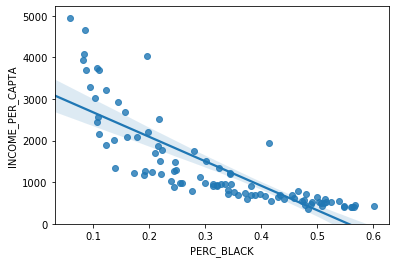

In [112]:
sns.regplot(x='PERC_BLACK', y='INCOME_PER_CAPTA', data=District)
plt.ylim(0,)

In [113]:
pearson_coef, p_value = stats.pearsonr(District['PERC_BLACK'], District['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.8170894312959299  with a P-value of P = 3.278212047348941e-24


(0, 0.0027961294623558355)

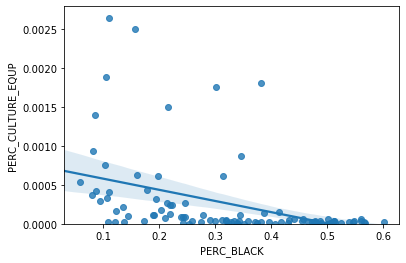

In [114]:
sns.regplot(x='PERC_BLACK', y='PERC_CULTURE_EQUP', data=District)
plt.ylim(0,)

In [115]:
pearson_coef, p_value = stats.pearsonr(District['PERC_BLACK'], District['PERC_CULTURE_EQUP'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.4149303403542528  with a P-value of P = 2.6301309434569084e-05


(0, 0.001742619680415351)

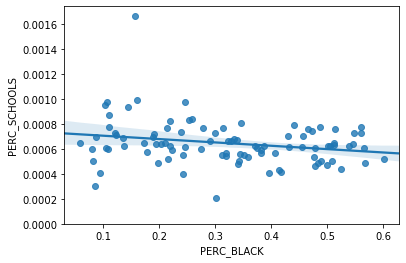

In [116]:
sns.regplot(x='PERC_BLACK', y='PERC_SCHOOLS', data=District)
plt.ylim(0,)

In [117]:
pearson_coef, p_value = stats.pearsonr(District['PERC_BLACK'], District['PERC_SCHOOLS'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.22892761686205754  with a P-value of P = 0.024863042345446253


(0, 0.00044314177996977657)

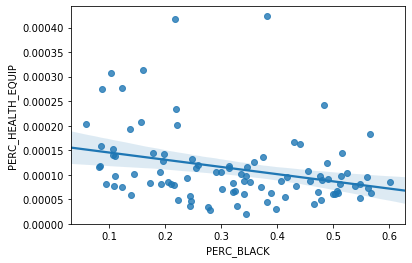

In [118]:
sns.regplot(x='PERC_BLACK', y='PERC_HEALTH_EQUIP', data=District)
plt.ylim(0,)

In [119]:
pearson_coef, p_value = stats.pearsonr(District['PERC_BLACK'], District['PERC_HEALTH_EQUIP'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.2965190544759442  with a P-value of P = 0.0033516445854855567


(0, 0.042583262355726785)

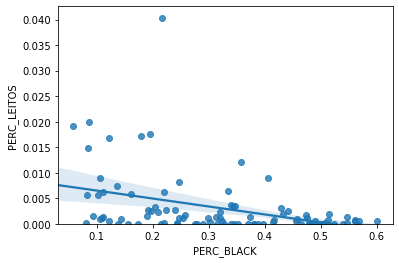

In [120]:
sns.regplot(x='PERC_BLACK', y='PERC_LEITOS', data=District)
plt.ylim(0,)

In [121]:
pearson_coef, p_value = stats.pearsonr(District['PERC_BLACK'], District['PERC_LEITOS'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.39307811546210625  with a P-value of P = 7.444491517151547e-05


WHITE PEOPLE

(0, 5222.135345323904)

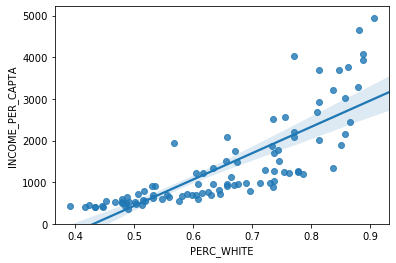

In [122]:
sns.regplot(x='PERC_WHITE', y='INCOME_PER_CAPTA', data=District)
plt.ylim(0,)

In [123]:
pearson_coef, p_value = stats.pearsonr(District['PERC_WHITE'], District['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.8070564754629121  with a P-value of P = 3.1464332612695534e-23


(0, 0.0027956007085672245)

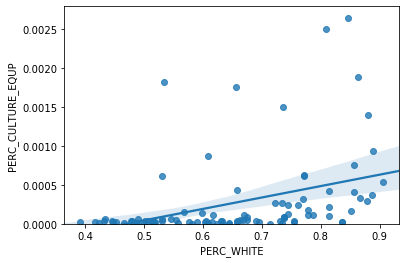

In [124]:
sns.regplot(x='PERC_WHITE', y='PERC_CULTURE_EQUP', data=District)
plt.ylim(0,)

In [125]:
pearson_coef, p_value = stats.pearsonr(District['PERC_WHITE'], District['PERC_CULTURE_EQUP'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.39067480552196565  with a P-value of P = 8.310631495373544e-05


(0, 0.001742619680415351)

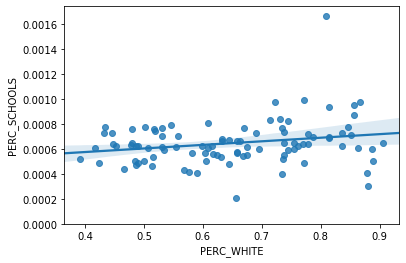

In [128]:
sns.regplot(x='PERC_WHITE', y='PERC_SCHOOLS', data=District)
plt.ylim(0,)

In [127]:
pearson_coef, p_value = stats.pearsonr(District['PERC_WHITE'], District['PERC_SCHOOLS'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.22496464720879644  with a P-value of P = 0.027548995953717785


(0, 0.00044314177996977657)

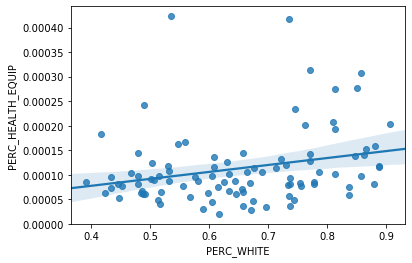

In [129]:
sns.regplot(x='PERC_WHITE', y='PERC_HEALTH_EQUIP', data=District)
plt.ylim(0,)

In [130]:
pearson_coef, p_value = stats.pearsonr(District['PERC_WHITE'], District['PERC_HEALTH_EQUIP'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.262626233881216  with a P-value of P = 0.009736798524530946


(0, 0.04256565443714446)

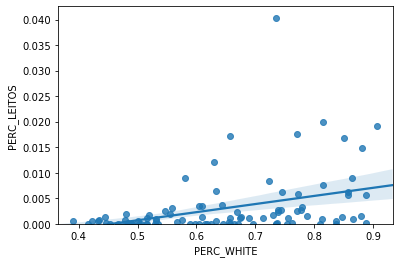

In [131]:
sns.regplot(x='PERC_WHITE', y='PERC_LEITOS', data=District)
plt.ylim(0,)

In [132]:
pearson_coef, p_value = stats.pearsonr(District['PERC_WHITE'], District['PERC_LEITOS'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.36914449022611084  with a P-value of P = 0.00021466883451653064


MEN AND WOMEN

(0, 5277.992899816032)

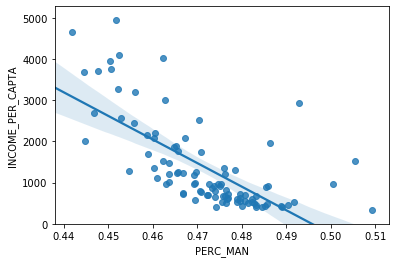

In [133]:
sns.regplot(x='PERC_MAN', y='INCOME_PER_CAPTA', data=District)
plt.ylim(0,)

In [134]:
pearson_coef, p_value = stats.pearsonr(District['PERC_MAN'], District['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.6942955688734946  with a P-value of P = 4.361287499926767e-15


(0, 5317.626712512326)

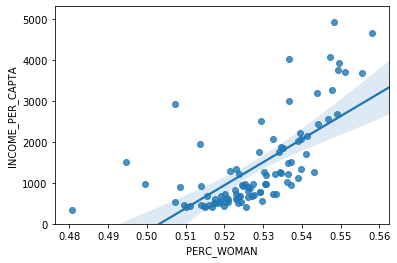

In [135]:
sns.regplot(x='PERC_WOMAN', y='INCOME_PER_CAPTA', data=District)
plt.ylim(0,)

In [136]:
pearson_coef, p_value = stats.pearsonr(District['PERC_WOMAN'], District['INCOME_PER_CAPTA'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.6876696602137802  with a P-value of P = 1.0030213089943034e-14


### 3.5 Clustering using k-means

K-means is vastly used for clustering in many data science applications, especially useful if you need to quickly discover insights from unlabeled data. In this study, I used k-Means for segmentation.

##### CENSUS SECTOR

Based on the exploratory analysis of the data, the percentages of white population, percentages of black population and per capita income of the sector were used to compose this model.

In [7]:
base= Summary_sector[['CD_SETOR','LAT', 'LONG', 'PERC_BLACK', 'PERC_WHITE', 'INCOME_PER_CAPTA']]

In [8]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

The data were normalized on the standard deviation due to the different magnitude of the per capita income data with the population proportions. The method used to normalize was StandardScaler ().
The centroid initialization method chosen was “k-means ++”, which intelligently selects the initial centers for the cluster to accelerate convergence. The number of defined clusters was 5. The number of times the algorithm was run with different centroid seeds was 12.


In [9]:
from sklearn.preprocessing import StandardScaler
X = base.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.45189206, -0.85461708, -1.46137573,  1.46984909,  2.85177763],
       [ 0.10718537,  0.40478047, -0.83845187,  1.02608096, -0.09146605],
       [ 0.12206531,  0.4277173 , -0.74088035,  0.92112529, -0.23900606],
       ...,
       [ 0.64838353,  1.70981102,  0.8451222 , -0.7680664 , -0.71641075],
       [ 0.6435489 ,  1.71821624,  1.12742199, -1.09574259, -0.68923792],
       [ 0.3679917 ,  1.94383777,  1.62902678, -1.53494915, -0.66543546]])

In [10]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[2 0 1 ... 1 1 1]


In [12]:
base["Clus"] = labels
base.head(5)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CD_SETOR,LAT,LONG,PERC_BLACK,PERC_WHITE,INCOME_PER_CAPTA,Clus
0,355030802000076,-23.53822883899994,-46.71332882699994,0.049270,0.906934,5097.750000,2
1,355030801000001,-23.567837779999934,-46.570826168999986,0.176179,0.820099,1126.274194,0
2,355030801000002,-23.566559651999967,-46.56823083399996,0.196057,0.799562,927.190581,1
3,355030801000003,-23.56859691899996,-46.56752940999996,0.153600,0.833600,809.059200,1
4,355030801000004,-23.570316633999937,-46.56888325999995,0.234266,0.751748,779.739510,1


In [13]:
base.groupby('Clus').mean()

,PERC_BLACK,PERC_WHITE,INCOME_PER_CAPTA
Clus,,,
0,0.187144,0.768065,1508.495264
1,0.456644,0.517439,549.916204
2,0.070113,0.887692,5057.181457
3,0.073244,0.888083,10074.686626
4,0.091343,0.850705,3068.022920


In [15]:
base.groupby('Clus').count()

,CD_SETOR,LAT,LONG,PERC_BLACK,PERC_WHITE,INCOME_PER_CAPTA
Clus,,,,,,
0,3504,3504,3504,3504,3504,3504
1,11988,11988,11988,11988,11988,11988
2,901,901,901,901,901,901
3,67,67,67,67,67,67
4,1903,1903,1903,1903,1903,1903


In [49]:
base[['LAT', 'LONG']].min()

LAT    -23.388459
LONG   -46.365686
dtype: float64

In [50]:
base[['LAT', 'LONG']].max()

LAT    -23.987357
LONG   -46.820327
dtype: float64

In [48]:
base.dtypes

CD_SETOR             object
LAT                 float64
LONG                float64
PERC_BLACK          float64
PERC_WHITE          float64
INCOME_PER_CAPTA    float64
Clus                 object
dtype: object

DISTRICT

Based on the exploratory analysis of the data, the following were used to compose this model: the percentages of the white population, the percentages of the black population, the per capita income of the sector, the percentage of men and women, the number of schools per inhabitant, the number of students per inhabitant, the number of cultural facilities per inhabitant, the amount of health facilities per inhabitant and the number of hospital beds per district.

In [58]:
base_dist= District[['CD_DIST', 'PERC_WHITE', 'PERC_BLACK','PERC_MAN', 'PERC_WOMAN', 'INCOME_PER_CAPTA', 'PERC_SCHOOLS', 'PERC_STUDENTS', 'PERC_CULTURE_EQUP', 'PERC_HEALTH_EQUIP', 'PERC_LEITOS']]

In [35]:
base_dist.head()

,CD_DIST,PERC_WHITE,PERC_BLACK,PERC_MAN,PERC_WOMAN,INCOME_PER_CAPTA,PERC_SCHOOLS,PERC_STUDENTS,PERC_CULTURE_EQUP,PERC_HEALTH_EQUIP,PERC_LEITOS
0,355030801,0.836776,0.137931,0.460200,0.539800,1352.489931,0.000624,0.169686,0.000024,0.000059,0.000071
1,355030802,0.887399,0.080595,0.450402,0.549598,3943.681912,0.000603,0.244985,0.000371,0.000116,0.000139
2,355030803,0.490761,0.502057,0.491793,0.507190,527.921696,0.000623,0.256077,0.000061,0.000061,0.000000
3,355030804,0.695867,0.275334,0.474002,0.525998,794.428901,0.000603,0.220682,0.000022,0.000033,0.000000
4,355030805,0.614825,0.370745,0.466795,0.533205,739.852568,0.000627,0.231407,0.000019,0.000076,0.000000


The centroid initialization method chosen was “k-means ++”, which intelligently selects the initial centers for the cluster to accelerate convergence. The number of defined clusters was 5. The number of times the algorithm was run with different centroid seeds was 12.

In [59]:
from sklearn.preprocessing import StandardScaler
X = base_dist.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.35443797e+00, -1.21666772e+00, -8.76356439e-01,
         9.13179788e-01, -2.79712192e-02, -1.35151080e-01,
        -4.64958107e-01, -4.67170344e-01, -7.28939665e-01,
        -5.08694053e-01],
       [ 1.72141477e+00, -1.59902556e+00, -1.62494695e+00,
         1.65700769e+00,  2.37340427e+00, -2.53301314e-01,
        -6.02414039e-02,  2.02844875e-01,  3.96868537e-02,
        -4.97163389e-01],
       [-1.15388148e+00,  1.21159400e+00,  1.53742236e+00,
        -1.56247442e+00, -7.92136115e-01, -1.42304987e-01,
        -6.19832306e-04, -3.95461398e-01, -7.03549511e-01,
        -5.20574941e-01],
       [ 3.32967408e-01, -3.00361117e-01,  1.78126026e-01,
        -1.34593958e-01, -5.45151764e-01, -2.56027877e-01,
        -1.90860599e-01, -4.69529483e-01, -1.07043096e+00,
        -5.20574941e-01],
       [-2.54520092e-01,  3.35910285e-01, -3.72534839e-01,
         4.12563550e-01, -5.95730135e-01, -1.17168982e-01,
        -1.33217305e-01, -4.75924198e-01, -4.98185943e-01,
        -5.

In [60]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[3 1 0 0 0 4 4 3 3 3 0 2 0 2 4 2 0 0 0 3 3 0 0 0 0 1 3 0 3 0 0 1 0 3 1 0 0
 3 0 3 3 0 0 0 1 0 0 4 2 3 3 0 2 1 0 3 0 0 3 4 0 1 3 0 0 3 3 3 2 2 4 3 0 0
 0 0 4 3 2 2 0 3 2 0 3 3 0 4 0 1 3 0 3 2 3 0]


In [61]:
base_dist["Clus"] = labels
base_dist.head(5)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CD_DIST,PERC_WHITE,PERC_BLACK,PERC_MAN,PERC_WOMAN,INCOME_PER_CAPTA,PERC_SCHOOLS,PERC_STUDENTS,PERC_CULTURE_EQUP,PERC_HEALTH_EQUIP,PERC_LEITOS,Clus
0,355030801,0.836776,0.137931,0.460200,0.539800,1352.489931,0.000624,0.169686,0.000024,0.000059,0.000071,3
1,355030802,0.887399,0.080595,0.450402,0.549598,3943.681912,0.000603,0.244985,0.000371,0.000116,0.000139,1
2,355030803,0.490761,0.502057,0.491793,0.507190,527.921696,0.000623,0.256077,0.000061,0.000061,0.000000,0
3,355030804,0.695867,0.275334,0.474002,0.525998,794.428901,0.000603,0.220682,0.000022,0.000033,0.000000,0
4,355030805,0.614825,0.370745,0.466795,0.533205,739.852568,0.000627,0.231407,0.000019,0.000076,0.000000,0


In [62]:
base_dist.groupby('Clus').mean()

,PERC_WHITE,PERC_BLACK,PERC_MAN,PERC_WOMAN,INCOME_PER_CAPTA,PERC_SCHOOLS,PERC_STUDENTS,PERC_CULTURE_EQUP,PERC_HEALTH_EQUIP,PERC_LEITOS
Clus,,,,,,,,,,
0,0.524219,0.463949,0.479619,0.519911,582.759468,0.000605,0.249912,0.000029,0.000091,0.001135
1,0.856998,0.100675,0.450219,0.549441,4103.439963,0.000599,0.197199,0.001066,0.000160,0.010987
2,0.743171,0.204339,0.463927,0.534534,1952.836897,0.000687,0.245077,0.000304,0.000133,0.005620
3,0.689956,0.272490,0.472186,0.527465,1138.416927,0.000652,0.290862,0.000248,0.000106,0.001762
4,0.818893,0.131400,0.461232,0.538157,2832.373376,0.000847,0.241316,0.000694,0.000178,0.006430


In [63]:
base_dist.groupby('Clus').count()

,CD_DIST,PERC_WHITE,PERC_BLACK,PERC_MAN,PERC_WOMAN,INCOME_PER_CAPTA,PERC_SCHOOLS,PERC_STUDENTS,PERC_CULTURE_EQUP,PERC_HEALTH_EQUIP,PERC_LEITOS
Clus,,,,,,,,,,,
0,41,41,41,41,41,41,41,41,41,41,41
1,8,8,8,8,8,8,8,8,8,8,8
2,11,11,11,11,11,11,11,11,11,11,11
3,28,28,28,28,28,28,28,28,28,28,28
4,8,8,8,8,8,8,8,8,8,8,8


In [86]:
base_dist

,CD_DIST,PERC_WHITE,PERC_BLACK,PERC_MAN,PERC_WOMAN,INCOME_PER_CAPTA,PERC_SCHOOLS,PERC_STUDENTS,PERC_CULTURE_EQUP,PERC_HEALTH_EQUIP,PERC_LEITOS,Clus
0,355030801,0.836776,0.137931,0.460200,0.539800,1352.489931,0.000624,0.169686,0.000024,0.000059,0.000071,4
1,355030802,0.887399,0.080595,0.450402,0.549598,3943.681912,0.000603,0.244985,0.000371,0.000116,0.000139,2
2,355030803,0.490761,0.502057,0.491793,0.507190,527.921696,0.000623,0.256077,0.000061,0.000061,0.000000,1
3,355030804,0.695867,0.275334,0.474002,0.525998,794.428901,0.000603,0.220682,0.000022,0.000033,0.000000,1
4,355030805,0.614825,0.370745,0.466795,0.533205,739.852568,0.000627,0.231407,0.000019,0.000076,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91,355030892,0.644625,0.340197,0.466791,0.532478,723.293314,0.000477,0.198662,0.000000,0.000062,0.000038,1
92,355030893,0.786583,0.189684,0.469341,0.530659,1186.577157,0.000700,0.211354,0.000115,0.000106,0.001631,4
93,355030894,0.670051,0.279147,0.470818,0.528859,1755.592516,0.000765,0.207809,0.000111,0.000028,0.000000,0
94,355030895,0.668859,0.320026,0.475136,0.524734,929.922292,0.000542,0.189857,0.000047,0.000083,0.002239,4


#### Predictive model SVM.

SVM works by mapping data to a large-sized resource space, so that data points can be categorized, even when data is not linearly separable. A separator between the categories is found and the data is transformed so that the separator can be drawn as a hyperplane. After that, the characteristics of the new data can be used to predict the group to which a new record should belong.

District

In [42]:
from sklearn import preprocessing

Given the 5 groups created based on data from the city of São Paulo, this model aims to classify a district in another city based on information on the percentages of white population, the percentages of black population, the per capita income of the sector, the percentage of men and women, the number of schools per capita, the number of students per capita, the amount of cultural facilities per capita, the amount of health facilities per capita and the number of hospital beds per district.

In [43]:
y = base_dist['Clus'].values
y[0:5]

array([1, 2, 3, 3, 3], dtype=int32)

In [44]:
X = base_dist[['PERC_WHITE', 'PERC_BLACK','PERC_MAN', 'PERC_WOMAN', 'INCOME_PER_CAPTA', 'PERC_SCHOOLS', 'PERC_STUDENTS', 'PERC_CULTURE_EQUP', 'PERC_HEALTH_EQUIP', 'PERC_LEITOS']]

The data were normalized on the standard deviation due. The method used to normalize was StandardScaler (). Then they are divided into training and test data in the proportion of 80% for training and 20% for testing. The training sample had 76 sectors and the test sample had 20.

In [45]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.35443797e+00, -1.21666772e+00, -8.76356439e-01,
         9.13179788e-01, -2.79712192e-02, -1.35151080e-01,
        -4.64958107e-01, -4.67170344e-01, -7.28939665e-01,
        -5.08694053e-01],
       [ 1.72141477e+00, -1.59902556e+00, -1.62494695e+00,
         1.65700769e+00,  2.37340427e+00, -2.53301314e-01,
        -6.02414039e-02,  2.02844875e-01,  3.96868537e-02,
        -4.97163389e-01],
       [-1.15388148e+00,  1.21159400e+00,  1.53742236e+00,
        -1.56247442e+00, -7.92136115e-01, -1.42304987e-01,
        -6.19832306e-04, -3.95461398e-01, -7.03549511e-01,
        -5.20574941e-01],
       [ 3.32967408e-01, -3.00361117e-01,  1.78126026e-01,
        -1.34593958e-01, -5.45151764e-01, -2.56027877e-01,
        -1.90860599e-01, -4.69529483e-01, -1.07043096e+00,
        -5.20574941e-01],
       [-2.54520092e-01,  3.35910285e-01, -3.72534839e-01,
         4.12563550e-01, -5.95730135e-01, -1.17168982e-01,
        -1.33217305e-01, -4.75924198e-01, -4.98185943e-01,
        -5.

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (76, 10) (76,)
Test set: (20, 10) (20,)


Then SVM functionality was imported from the sklearn library. The SVM algorithm offers a choice of kernel functions to perform its processing. Basically, mapping data in a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function and can be of different types. In this case, the linear function was chosen.

In [47]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 4, 0, 4, 2], dtype=int32)

In [48]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

**EVALUATION MODEL**

In [49]:
yhat=clf.predict(X)
SVMJaccard = jaccard_similarity_score(y, yhat)
SVMF1 = f1_score(y, yhat, average='weighted')
print("SVM F1-score: %.2f" % SVMF1)
print("SVM Jaccard score: %.2f" % SVMJaccard)

SVM F1-score: 0.93
SVM Jaccard score: 0.93


CENSUS SECTOR

In [50]:
y = base['Clus'].values
y[0:5]

array([2, 0, 1, 1, 1], dtype=int32)

In [51]:
X = base[['PERC_WHITE', 'PERC_BLACK','INCOME_PER_CAPTA']]

In [52]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.46984909, -1.46137573,  2.85177763],
       [ 1.02608096, -0.83845187, -0.09146605],
       [ 0.92112529, -0.74088035, -0.23900606],
       [ 1.09507614, -0.94927799, -0.32655272],
       [ 0.67677505, -0.55333464, -0.34828142]])

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (14690, 3) (14690,)
Test set: (3673, 3) (3673,)


In [55]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 2, 0, 1, 1], dtype=int32)

**EVALUATION MODEL**

In [56]:
yhat=clf.predict(X)
SVMJaccard = jaccard_similarity_score(y, yhat)
SVMF1 = f1_score(y, yhat, average='weighted')
print("SVM F1-score: %.2f" % SVMF1)
print("SVM Jaccard score: %.2f" % SVMJaccard)

SVM F1-score: 1.00
SVM Jaccard score: 1.00


## 4. RESULTS

With the sectors clustered and with the prediction model created, the first step is to place the information on the map to visualize the spatial distribution and understand if there is a spatial continuity of the clusters.
To do this we used the folium library and the following configuration:

In [ ]:
setor_polygon = r'setor_polygons2.json'


# let Folium determine the scale.
sp_map_polygon = folium.Map(location=[-23.547152, -46.634934], zoom_start=11, tiles='Mapbox Bright')
sp_map_polygon.choropleth(
    geo_data=setor_polygon,
    data=base,
    columns=['CD_SETOR','Clus'],
    key_on='feature.properties.CD_SETOR',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Clusters',
    reset=True
)
sp_map_polygon

Groups 2, 3 and 4 where the average percentage of the black population is below 10% (far below 37% of the total city), with an average income above R $ 3,068 are concentrated in the most central area of the city with minor exceptions of sectors.

Group 0, which has an average of 18% blacks, has a lower average income around R $ 1,508 and is spatially on the edge of the central areas.

Group 1, which represents the majority of the city's sectors, has an average of 45.6% of the black population and has the lowest average per capita income in the city. These sectors are distributed in the peripheral parts of the city of São Paulo.

The SVM predictive model showed a high capacity to classify this same condition in other Brazilian cities to understand whether this spatial phenomenon is repeated.

The following model showed the classification of the districts using information other than the percentages of the white population, the percentages of the black population, the per capita income of the sector, the percentage of men and women, the number of schools per inhabitant, the number of students per inhabitant, the amount of cultural equipment per inhabitant, the amount of health equipment per inhabitant and the number of hospital beds per district.

As a result we can see the map below:


In [ ]:
dist_polygon = r'dist_polygons2.json'


# let Folium determine the scale.
sp_dist_polygon = folium.Map(location=[-23.547152, -46.634934], zoom_start=11, tiles='Mapbox Bright')
sp_dist_polygon.choropleth(
    geo_data=dist_polygon,
    data=base_dist,
    columns=['CD_DIST','Clus'],
    key_on='feature.properties.CD_DIST',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Clusters',
    reset=True
)
sp_dist_polygon

Groups 4 and 1 represent 16 districts of the city and are located in the most central part. The average white population is over 80% and black below 15% (in contrast to the representativeness of 37% of the black population in the city). These clusters have the best average per capita income and group 4 has the best average of schools per inhabitant and the best average of health equipment. Group 1, on the other hand, had the best average of cultural equipment and hospital beds. These groups together show that there is a concentration of structures in areas predominantly occupied by white people.

Groups 2 and 3 that are on the edges of groups 1 and 4. They function as a kind of geographical boundary between group 0 and the others. All averages have no specific prominence, they are in the middle both geographically and by population and structure. However, the average black population is still below the city, 20.4% for 2 and 27.2% for 3.

Finally, group 0 with the highest average percentage of blacks in the city and with the worst indicators of structure forming the peripheral areas of the city.
The SVM predictive model showed a high capacity to classify this same condition in other Brazilian cities to understand whether this spatial phenomenon is repeated.


## 5. Discussions

Income inequality in the city of São Paulo and access to urban equipment showed a strong correlation with color. Places with a higher percentage of whites have higher per capita income and better distribution of cultural, education and health structures.
To remedy this inequality, it is necessary to look at the problem in a social way. Brazilians often deny the existence of racism in our society, but it is no coincidence that poverty is concentrated in places where the majority is black.
It is necessary for governments to face this problem and adopt policies for the inclusion and distribution of income aimed at the black population. Creating a quota system at universities and encouraging companies to hire more black people through tax incentives may be an option.
Another suggestion is to bring more structures to the poorest parts of the city (where the black population is concentrated). Improving transportation, building cultural centers and schools helps to stimulate people in the search for knowledge and capacity. Increasing education increases access to income.


## 6. Conclusion

Racism is related to inequality in the distribution of Brazilian income and is reflected in the occupation of spaces in the city of São Paulo.
The data shown in this study of the correlation between the percentage of black residents, lower income, distance from central and more structured parts of the city, show that São Paulo needs inclusion policies that take into account the color / race factor.
It is necessary to consider that racism is a structural problem in Brazilian society and to initiate projects that ensure that the black population has more access to education and opportunities to improve their income. Only then can we reduce social inequality in Brazil.
